C:\Users\jerem\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


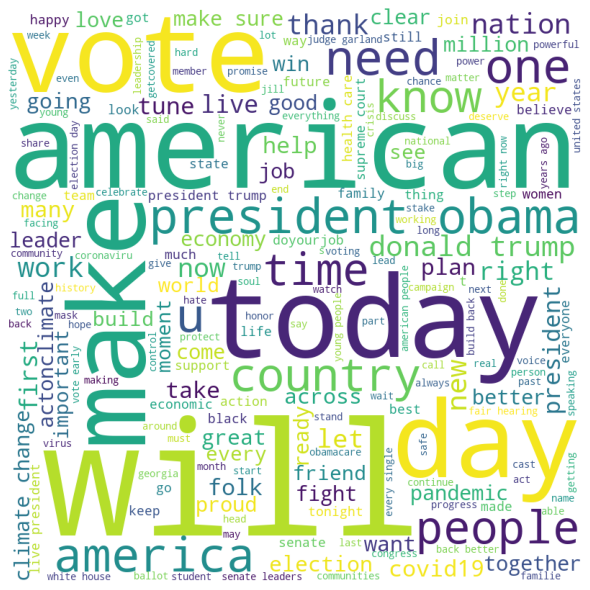

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           196256    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 212,907
Trainable params: 212,907
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: data/binary_crossentropy\assets
Epoch 1/100
74/74 [=========================

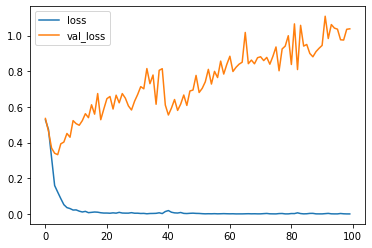

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud, STOPWORDS
#Importing Cleaned CSV Data Corpus mined from Twitter
df= pd.read_csv('main corpus/sentiment_included.csv')

#Selecting Relevant Columns
tweet_df = df[['tweet_text','sentiment']]
# sorting by tweet_text
tweet_df.sort_values('tweet_text', inplace = True)
# Deletes any duplicate tweet_text 
tweet_df.drop_duplicates(subset = 'tweet_text',
                     keep = False, inplace = True)

#Since I'm classifying tweets that are either positive or negative I am dropping the neutral tweets for now
tweet_df = tweet_df[tweet_df["sentiment"] != 'Neutral']

sentiment_label = tweet_df.sentiment.factorize()

#Preprocessing
# Removing Stop Words
remove_stopwords(tweet_df.tweet_text.values.astype(str))

#Preparing the text for NLP
tweet = tweet_df.tweet_text.values
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

comment_words = ''
stopwords = set(STOPWORDS)

"""
Code for wordcloud, taken from GeeksforGeeks & repurposed for my corpus 
https://www.geeksforgeeks.org/generating-word-cloud-python/
"""
# Iterate through the csv file
for val in tweet_df['tweet_text']:
      
    # typecast each val to string
    val = str(val)
    # split the value
    tokens = val.split()    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

# print(tokenizer.word_index)
# print(tweet[0])
# print(encoded_docs[0])
# print(padded_sequence[0])

 # Building the model
MODEL_FILE= "data/binary_crossentropy"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
#Saving the model
model.save(MODEL_FILE)
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.3, epochs=100, batch_size=32)
test_word ="This makes me so happy"

tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
print("====================================")
print(sentiment_label[1][prediction])
print()
plt.plot(history.history['loss'], label  = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
